# Ensure the boundary in $\pm x$, $\pm y$, and $+ z$ is big enough for $\rho_\text{air}$.

The air is very resistive, and EM waves travel relatively VERY far (and fast) in the air, in comparison to the subsurface. The skind depth is given by $\delta = 503.3 \sqrt{\rho/f}$. For a frequency of $f=1\,$Hz this yields:

- $\rho=0.3: \delta = 275.7\,$m
- $\rho=1: \delta = 503.3\,$m
- $\rho=1e8: \delta = 5,033,000\,$m $\Rightarrow 5033\,$km (!)

The buffer zone around our zone of interest should ideally be several skin depths.

The important bit is that the resistivity of air has to be taken into account also for the horizontal directions, not only for positive $z$ (upwards into the sky). This is an example notebook to test boundaries on a simple marine model (air, water, subsurface) and compare them to the 1D result.

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')

## Model, Survey, and Analytical Solution
Watch out: empymod has positive z downwards, emg3d has positive z upwards!

In [3]:
water_depth = 500                   # 500 m water depth
off = np.linspace(2000, 7000, 501)  # Offsets
src = [0, 0, water_depth-50]        # Source at origin, 50 m above seafloor
rec = [off, off*0, water_depth]     # Receivers on the seafloor
depth = [0, water_depth]            # Simple model
res = [1e8, 0.3, 1]                 # Simple model
freq = 0.1                          # Frequency

# Calculate analytical solution
epm = empymod.dipole(src, rec, depth, res, freq)


:: empymod END; runtime = 0:00:00.149605 :: 1 kernel call(s)



## 3D Modelling

In [4]:
# Parameter we keep the same for both grids
x_inp = {'fixed': src[0], 'domain': [src[0][0]-500, off[-1]+500]}
y_inp = {'fixed': src[1], 'domain': [src[1][0], src[1][0]]}
z_inp = {'fixed': [0, -water_depth-100, 100], 'domain': [-600, 100]}
inp = {'freq': freq, 'alpha': [1, 1.25, 0.01], 'min_width': 100}

# Solver parameters
solver_inp = {'verb': 3, 'sslsolver': True, 'semicoarsening': True, 'linerelaxation': True}

## 1st grid, only considering $\rho_\text{air}$ for $+z$

Here we are in the water, so the signal is attenuated before it enters the air. So we don't use the resistivity of air to calculate the required boundary, but 100 Ohm.m instead. (100 is the result of a quick parameter test with $\rho=1e4, 1e3, 1e2, 1e1$, and the result was that after 100 there is not much improvement any longer.)

Also note that the function `emg3d.utils.get_hx_h0` internally uses six times the skin depth for the boundary. For
$\rho$ = 100 Ohm.m and $f$ = 0.1 Hz, the skin depth $\delta$ is roughly 16 km, which therefore results in a boundary of roughly 96 km.

See the documentation of `emg3d.utils.get_hx_h0` for more information on how the grid is created.

In [5]:
# Get cell widths and origin in each direction
xx_1, x0_1 = emg3d.utils.get_hx_h0(res=[res[1], res[2]], **x_inp, **inp)
yy_1, y0_1 = emg3d.utils.get_hx_h0(res=[res[1], res[2]], **y_inp, **inp)
zz_1, z0_1 = emg3d.utils.get_hx_h0(res=[res[1], res[2], 100], **z_inp, **inp)

# Create grid and correpsoding model
grid_1 = discretize.TensorMesh([xx_1, yy_1, zz_1], x0=np.array([x0_1, y0_1, z0_1]))
res_1 = res[2]*np.ones(grid_1.nC)
res_1[grid_1.gridCC[:, 2] > -water_depth] = res[1]
res_1[grid_1.gridCC[:, 2] > 0] = res[0]
model_1 = emg3d.utils.Model(grid_1, res_x=res_1, freq=freq)
#grid_1.plot_3d_slicer(np.log10(model_1.res_x), zlim=(-2000, 100), clim=[-1, 2])

# Define source and solve the system
sfield_1 = emg3d.utils.get_source_field(grid_1, [src[0], src[1], -src[2], 0, 0], freq)
efield_1 = emg3d.solver.solver(grid_1, model_1, sfield_1, **solver_inp)

   Skin depth (m/l-r)  [m] : 872 / 1592
   Survey domain       [m] : -500 - 7500
   Calculation domain  [m] : -10049 - 17049
   Final extent        [m] : -10235 - 17235
   Min/max cell width  [m] : 100 / 100 / 985
   Alpha survey/calc       : 1.000 / 1.100
   Number of cells (s/c/r) : 128 (80/48/0)

   Skin depth (m/l-r)  [m] : 872 / 1592
   Survey domain       [m] : 0 - 0
   Calculation domain  [m] : -9549 - 9549
   Final extent        [m] : -9578 - 9578
   Min/max cell width  [m] : 100 / 100 / 1745
   Alpha survey/calc       : 1.000 / 1.210
   Number of cells (s/c/r) : 32 (2/30/0)

   Skin depth (m/l/r)  [m] : 872 / 1592 / 15916
   Survey domain       [m] : -600 - 100
   Calculation domain  [m] : -10149 - 95594
   Final extent        [m] : -10993 - 97110
   Min/max cell width  [m] : 100 / 100 / 17594
   Alpha survey/calc       : 1.000 / 1.220
   Number of cells (s/c/r) : 48 (7/41/0)


:: emg3d START :: 17:08:55 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   sem

## 2nd grid, considering $\rho_\text{air}$ for $\pm x$, $\pm y$, and $+z$

See comments below the heading of the 1st grid regarding boundary.

In [6]:
# Get cell widths and origin in each direction
xx_2, x0_2 = emg3d.utils.get_hx_h0(res=[res[1], 100], **x_inp, **inp)
yy_2, y0_2 = emg3d.utils.get_hx_h0(res=[res[1], 100], **y_inp, **inp)
zz_2, z0_2 = emg3d.utils.get_hx_h0(res=[res[1], res[2], 100], **z_inp, **inp)

# Create grid and correpsoding model
grid_2 = discretize.TensorMesh([xx_2, yy_2, zz_2], x0=np.array([x0_2, y0_2, z0_2]))
res_2 = res[2]*np.ones(grid_2.nC)
res_2[grid_2.gridCC[:, 2] > -water_depth] = res[1]
res_2[grid_2.gridCC[:, 2] > 0] = res[0]
model_2 = emg3d.utils.Model(grid_2, res_x=res_2, freq=freq)
#grid_2.plot_3d_slicer(np.log10(model_2.res_x), zlim=(-2000, 100), clim=[-1, 2])

# Define source and solve the system
sfield_2 = emg3d.utils.get_source_field(grid_2, [src[0], src[1], -src[2], 0, 0], freq)
efield_2 = emg3d.solver.solver(grid_2, model_2, sfield_2, **solver_inp)

   Skin depth (m/l-r)  [m] : 872 / 15916
   Survey domain       [m] : -500 - 7500
   Calculation domain  [m] : -95994 - 102994
   Final extent        [m] : -105879 - 112879
   Min/max cell width  [m] : 100 / 100 / 21176
   Alpha survey/calc       : 1.000 / 1.250
   Number of cells (s/c/r) : 128 (80/48/0)

   Skin depth (m/l-r)  [m] : 872 / 15916
   Survey domain       [m] : 0 - 0
   Calculation domain  [m] : -95494 - 95494
   Final extent        [m] : -110350 - 110350
   Min/max cell width  [m] : 100 / 100 / 16918
   Alpha survey/calc       : 1.000 / 1.180
   Number of cells (s/c/r) : 64 (2/62/0)

   Skin depth (m/l/r)  [m] : 872 / 1592 / 15916
   Survey domain       [m] : -600 - 100
   Calculation domain  [m] : -10149 - 95594
   Final extent        [m] : -10993 - 97110
   Min/max cell width  [m] : 100 / 100 / 17594
   Alpha survey/calc       : 1.000 / 1.220
   Number of cells (s/c/r) : 48 (7/41/0)


:: emg3d START :: 17:09:23 ::

   MG-cycle       : 'F'                 sslsolver : 'bi

## Plot receiver responses

In [7]:
# Interpolate fields at receiver positions
emg_1 = emg3d.utils.get_receiver(grid_1, efield_1.fx, (rec[0], rec[1], -rec[2]))
emg_2 = emg3d.utils.get_receiver(grid_2, efield_2.fx, (rec[0], rec[1], -rec[2]))

<IPython.core.display.Javascript object>


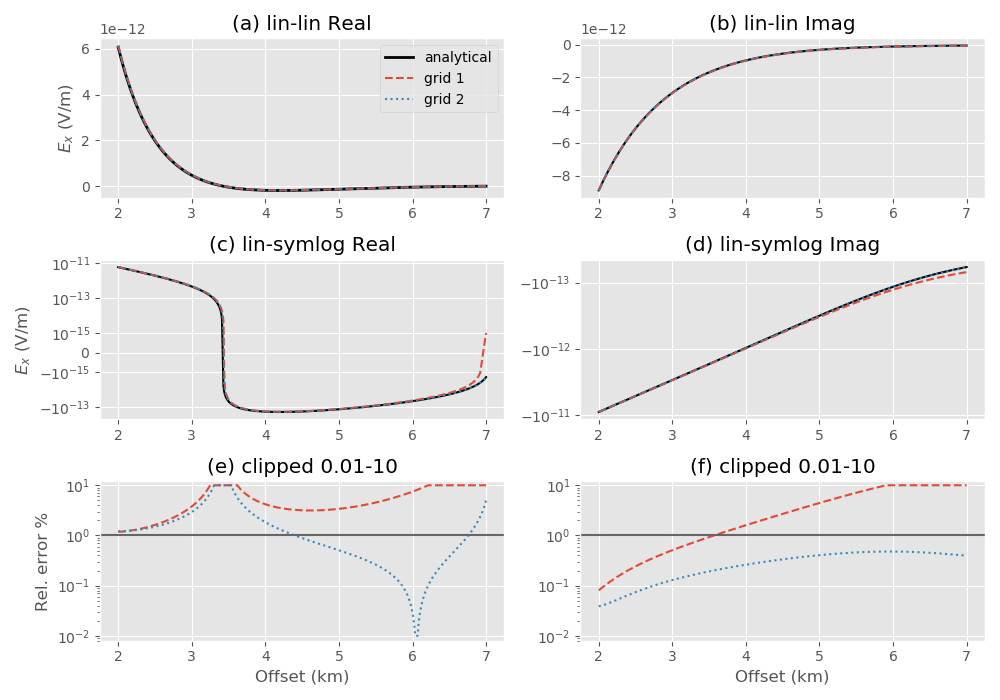

In [8]:
plt.figure(figsize=(10, 7))

# Real, log-lin
ax1 = plt.subplot(321)
plt.title('(a) lin-lin Real')
plt.plot(off/1e3, epm.real, 'k', lw=2, label='analytical')
plt.plot(off/1e3, emg_1.real, 'C0--', label='grid 1')
plt.plot(off/1e3, emg_2.real, 'C1:', label='grid 2')
plt.ylabel('$E_x$ (V/m)')
plt.legend()

# Real, log-symlog
ax3 = plt.subplot(323, sharex=ax1)
plt.title('(c) lin-symlog Real')
plt.plot(off/1e3, epm.real, 'k')
plt.plot(off/1e3, emg_1.real, 'C0--')
plt.plot(off/1e3, emg_2.real, 'C1:')
plt.ylabel('$E_x$ (V/m)')
plt.yscale('symlog', linthreshy=1e-15)

# Real, error
ax5 = plt.subplot(325, sharex=ax3)
plt.title('(e) clipped 0.01-10')

# Calculate the error
err_real_1 = np.clip(100*abs((epm.real-emg_1.real)/epm.real), 0.01, 10)
err_real_2 = np.clip(100*abs((epm.real-emg_2.real)/epm.real), 0.01, 10)

plt.ylabel('Rel. error %')
plt.plot(off/1e3, err_real_1, 'C0--')
plt.plot(off/1e3, err_real_2, 'C1:')
plt.axhline(1, color='.4')

plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Offset (km)')

# Imaginary, log-lin
ax2 = plt.subplot(322)
plt.title('(b) lin-lin Imag')
plt.plot(off/1e3, epm.imag, 'k')
plt.plot(off/1e3, emg_1.imag, 'C0--')
plt.plot(off/1e3, emg_2.imag, 'C1:')

# Imaginary, log-symlog
ax4 = plt.subplot(324, sharex=ax2)
plt.title('(d) lin-symlog Imag')
plt.plot(off/1e3, epm.imag, 'k')
plt.plot(off/1e3, emg_1.imag, 'C0--')
plt.plot(off/1e3, emg_2.imag, 'C1:')

plt.yscale('symlog', linthreshy=1e-15)

# Imaginary, error
ax6 = plt.subplot(326, sharex=ax2)
plt.title('(f) clipped 0.01-10')

# Calculate error
err_imag_1 = np.clip(100*abs((epm.imag-emg_1.imag)/epm.imag), 0.01, 10)
err_imag_2 = np.clip(100*abs((epm.imag-emg_2.imag)/epm.imag), 0.01, 10)

plt.plot(off/1e3, err_imag_1, 'C0--')
plt.plot(off/1e3, err_imag_2, 'C1:')
plt.axhline(1, color='.4')

plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Offset (km)')

plt.tight_layout()
plt.show()

## Plot entire fields to analyze and compare

### 1st grid

Upper plot shows the entire grid. One can see that the airwave attenuates to amplitudes in the order of 1e-17 at the boundary, absolutely good enough. However, the amplitudes in the horizontal directions are very high even at the boundaries $\pm x$ and $\pm y$.

<IPython.core.display.Javascript object>


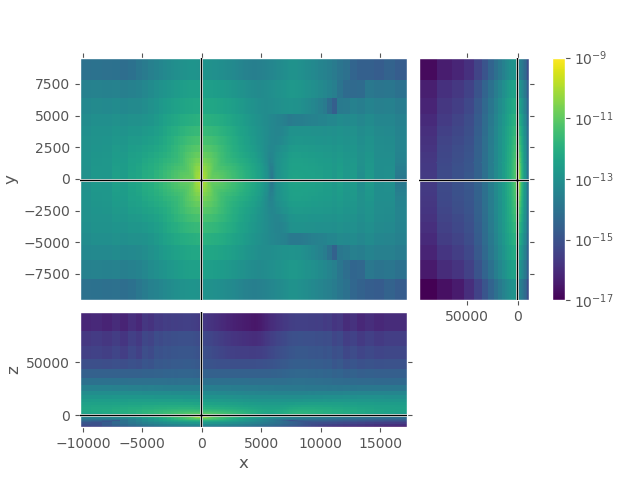

<IPython.core.display.Javascript object>


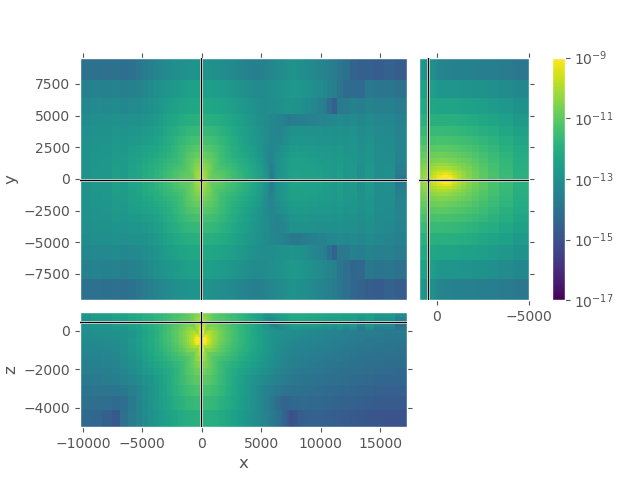

In [9]:
grid_1.plot_3d_slicer(
    efield_1.fx.ravel('F'), view='abs', vType='Ex', clim=[1e-17, 1e-9],
    xslice=src[0], yslice=src[1], zslice=rec[2],
    pcolorOpts={'norm': LogNorm()})
grid_1.plot_3d_slicer(
    efield_1.fx.ravel('F'), view='abs', vType='Ex', clim=[1e-17, 1e-9],
    zlim=[-5000, 1000],
    xslice=src[0], yslice=src[1], zslice=rec[2],
    pcolorOpts={'norm': LogNorm()})

### 2nd grid

Again, upper plot shows the entire grid. One can see that the field attenuated sufficiently in all directions. Lower plot show sthe same cut-out as the lower plot for the first grid, our zone of interest.

<IPython.core.display.Javascript object>


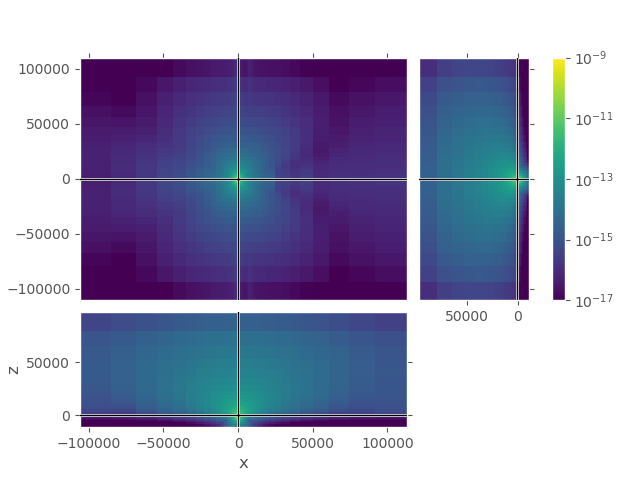

<IPython.core.display.Javascript object>


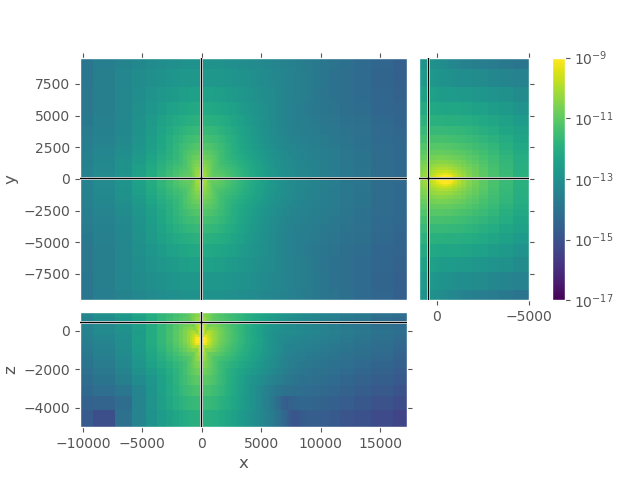

In [10]:
grid_2.plot_3d_slicer(
    efield_2.fx.ravel('F'), view='abs', vType='Ex', clim=[1e-17, 1e-9],
    xslice=src[0], yslice=src[1], zslice=rec[2],
    pcolorOpts={'norm': LogNorm()})
grid_2.plot_3d_slicer(
    efield_2.fx.ravel('F'), view='abs', vType='Ex', clim=[1e-17, 1e-9],
    xlim=[grid_1.vectorNx[0], grid_1.vectorNx[-1]],  # Show same square as for grid_1
    ylim=[grid_1.vectorNy[0], grid_1.vectorNy[-1]],  # Show same square as for grid_1
    zlim=[-5000, 1000],
    xslice=src[0], yslice=src[1], zslice=rec[2],
    pcolorOpts={'norm': LogNorm()})

In [11]:
emg3d.Report([empymod, discretize])

--------------------------------------------------------------------------------
  Date: Wed Oct 09 17:10:23 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

             1.9.0 : empymod
            0.4.10 : discretize
            1.17.2 : numpy
             1.3.1 : scipy
            0.45.1 : numba
         0.8.1dev0 : emg3d
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------